In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/annotated_all.data", 'rb') as filename:
  dataset = pickle.load(filename )

In [ ]:
print(dataset)

[{'class': 'OBJ', 'sentence': 'A garrison is an organization that an army installs.', 'pred_arg': (9, 5), 'label': 'Patient'}, {'class': 'OBJ', 'sentence': 'A garrison is an organization that an army installs.', 'pred_arg': (9, 8), 'label': 'Agent'}, {'class': 'OBJ', 'sentence': 'A garrison is an organization that a fort house.', 'pred_arg': (9, 5), 'label': 'Patient'}, {'class': 'OBJ', 'sentence': 'A garrison is an organization that a fort house.', 'pred_arg': (9, 8), 'label': 'Agent'}, {'class': 'OBJ', 'sentence': 'A garrison is an organization that a barracks hold.', 'pred_arg': (9, 5), 'label': 'Patient'}, {'class': 'OBJ', 'sentence': 'A garrison is an organization that a barracks hold.', 'pred_arg': (9, 8), 'label': 'Agent'}, {'class': 'OBJ', 'sentence': 'A garrison is an organization that a force besiege.', 'pred_arg': (9, 5), 'label': 'Patient'}, {'class': 'OBJ', 'sentence': 'A garrison is an organization that a force besiege.', 'pred_arg': (9, 8), 'label': 'Agent'}, {'class': '

In [ ]:
obj_data = []
sbj_data = []

for entry in dataset:
  if entry['class'] == "OBJ":
    obj_data.append(entry)
  else:
    sbj_data.append(entry)

In [ ]:
!pip install nltk


In [ ]:
import nltk
nltk.download('punkt')
#word_data = sbj_data[0]["sentence"]
#nltk_tokens = nltk.word_tokenize(word_data)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
obj_data_dict = []
max_length = 159
for example in obj_data:
  instance = {}
  instance['data'] = nltk.word_tokenize(example["sentence"])
  seq_len = len(instance['data'])
  pred_arg = list(example['pred_arg'])
  instance['label'] = 0 if example['label'] == "Agent" else 1

  instance['data'] = instance['data'] + ["UNK"]*(max_length-seq_len) + pred_arg
  assert len(instance['data']) == 161
  obj_data_dict.append(instance)

In [ ]:
sbj_data_dict = []
max_length = 159
for example in sbj_data:
  instance = {}
  instance['data'] = nltk.word_tokenize(example["sentence"])
  seq_len = len(instance['data'])
  pred_arg = list(example['pred_arg'])
  instance['label'] = 0 if example['label'] == "Agent" else 1

  instance['data'] = instance['data'] + ["UNK"]*(max_length-seq_len) + pred_arg
  assert len(instance['data']) == 161
  sbj_data_dict.append(instance)

In [ ]:
import numpy as np
import torch.nn as nn

import torch
from torch.utils.data import Dataset, DataLoader

class DecompDataset(Dataset):
  def __init__(self, data_dictionary):
    self.data = data_dictionary

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

Run Cells After This Block for a New Random Permutation

In [ ]:
import random
def my_collate(batch):
  sbj_data = [item[0]['data'] for item in batch]
  obj_data = [item[1]['data'] for item in batch]
  sbj_labels = [item[0]['label'] for item in batch]
  obj_labels = [item[1]['label'] for item in batch]
  return [sbj_data, obj_data, sbj_labels, obj_labels]

obj_data_random = obj_data_dict[0:1000]
sbj_data_random = sbj_data_dict[0:1000]
random.shuffle(obj_data_random)
random.shuffle(sbj_data_random)

my_batch_size = 10
train_data = DecompDataset(list(zip(sbj_data_random, obj_data_random)))
train_data_load = DataLoader(train_data, batch_size=my_batch_size, collate_fn=my_collate)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#!pip install pytorch-nlp

In [ ]:
from torchnlp.word_to_vector import GloVe
glove = GloVe(name='42B')

In [ ]:
class SPRL_Net(nn.Module):
  def __init__(self):
    super(SPRL_Net, self).__init__()
    self.emb_dim = 300
    self.embedding = glove
    self.encoding = torch.nn.LSTM(input_size=self.emb_dim, hidden_size=25, bidirectional=True)
    self.sharedLinear = torch.nn.Linear(in_features=100, out_features=20)
    self.ReLu = torch.nn.ReLU()
    self.outLinear = torch.nn.Linear(in_features = 20, out_features = 2)

  def forward(self, x):
    # Double check the dimension on this embedding layer
    embeddings = np.zeros((max_length, len(x), self.emb_dim), dtype=np.float32)
    for i in range(max_length):
      for j in range(len(x)):
        embeddings[i][j] = torch.Tensor(self.embedding[x[j][i]])
    embedding = torch.from_numpy(embeddings).to(device)
    assert embedding.shape == torch.Size([max_length,len(x), self.emb_dim])

    assert embedding.is_cuda
    encoded, (_,_) = self.encoding(embedding)
    assert encoded.is_cuda
    pred_arg_vectors = []
    for i in range(len(x)):
      pred = x[i][-2]-1
      arg = x[i][-1]-1
      pred_arg_vectors.append(torch.cat([encoded[pred][i], encoded[arg][i]]))
    pred_arg_vectors = torch.stack(pred_arg_vectors)
    shared = self.ReLu(self.sharedLinear(pred_arg_vectors))
    out = self.outLinear(shared)

    return out


net = SPRL_Net()
net.to(device)
learning_rate = .0001
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)


In [ ]:
import time
num_epochs = 15
loss_fn = torch.nn.CrossEntropyLoss()
train_epoch_losses = []
sbj_train_epoch_losses = []
obj_train_epoch_losses = []
sbj_accuracy_list = []
obj_accuracy_list = []

print("Starting Training")
#training loop:
for epoch in range(num_epochs):
  time1 = time.time() #timekeeping

  loss_sum = 0
  sbj_loss_sum =0
  obj_loss_sum = 0
  sbj_correct= 0
  sbj_total = 0
  obj_correct = 0
  obj_total = 0
  total = 0
  for i, example in enumerate(train_data_load):
      sbj_data = example[0]
      sbj_labels = torch.LongTensor(example[2]).to(device)
      obj_data = example[1]
      obj_labels = torch.LongTensor(example[3]).to(device)

      total+=1
    
    #loss calculation and gradient update:
      if i > 0 or epoch > 0:
        optimizer.zero_grad()
      sbj_outputs = net(sbj_data)
      sbj_preds = torch.argmax(sbj_outputs, dim=1)
      sbj_correct += sum(sbj_preds == sbj_labels)
      sbj_total+=10
      sbj_loss = loss_fn(sbj_outputs, sbj_labels)

      obj_outputs = net(obj_data)
      obj_preds = torch.argmax(obj_outputs, dim=1)
      obj_correct += sum(obj_preds == obj_labels)
      obj_total+=10
      obj_loss = loss_fn(obj_outputs, obj_labels)
      
      loss = sbj_loss + obj_loss
      loss.backward()
      loss_sum+=loss
      sbj_loss_sum+= sbj_loss
      obj_loss_sum+= obj_loss
      

      ##performing update:
      optimizer.step() 
  epoch_loss = loss_sum.cpu().data.numpy().item() / total
  sbj_epoch_loss = sbj_loss_sum.cpu().data.numpy().item() / total
  obj_epoch_loss = obj_loss_sum.cpu().data.numpy().item() / total
  train_epoch_losses.append(epoch_loss)
  sbj_train_epoch_losses.append(sbj_epoch_loss)
  obj_train_epoch_losses.append(obj_epoch_loss)
  sbj_accuracy_list.append(sbj_correct/sbj_total)
  obj_accuracy_list.append(obj_correct/obj_total)

  print("Epoch",epoch+1,':')
  # Training loss
  print('Train loss: %f' % (epoch_loss))
  print('Subject Train loss: %f' % (sbj_epoch_loss))
  print('Object Train loss: %f' % (obj_epoch_loss))
  print('Subject Accuracy: %f' % (sbj_correct/sbj_total))
  print('Object Accuracy: %f' % (obj_correct/obj_total))
  time2 = time.time() #timekeeping
  print('Elapsed time for epoch:',time2 - time1,'s')
  print('ETA of completion:',(time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')
  print()


Starting Training
tensor([[ 5.0420, -5.3754],
        [ 4.8422, -5.2558],
        [-4.8888,  6.0461],
        [ 4.6373, -5.0547],
        [ 4.1390, -4.3289],
        [-4.1203,  5.0720],
        [ 4.4109, -4.7397],
        [-4.2720,  5.2873],
        [-4.7237,  5.7353],
        [ 4.7564, -5.1396]], device='cuda:0', grad_fn=<AddmmBackward>)


AssertionError: ignored

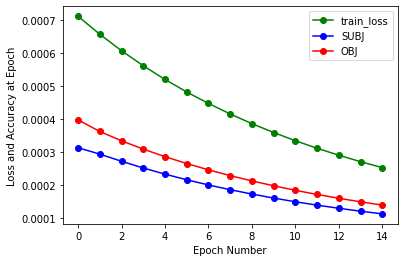

In [ ]:
import matplotlib.pyplot as plt

## Plotting batch-wise train loss curve:
plt.plot(train_epoch_losses, '-o', label = 'train_loss', color = 'green')
plt.plot(sbj_train_epoch_losses, '-o', label = 'SUBJ', color = 'blue')
plt.plot(obj_train_epoch_losses, '-o', label = 'OBJ', color = 'red')
plt.xlabel('Epoch Number')
plt.ylabel('Loss and Accuracy at Epoch')
plt.legend()
plt.show()